In recent years, attention has increasingly been paid to human resources (HR), since worker quality and skills represent a growth factor and a real competitive advantage for companies. After proving its mettle in sales and marketing, artificial intelligence is also becoming central to employee-related decisions within HR management. Organizational growth largely depends on staff retention. Losing employees frequently impacts the morale of the organization and hiring new employees is more expensive than retaining existing ones. 

You are working as a data scientist with HR Department of a large insurance company focused on sales team attrition. Insurance sales teams help insurance companies generate new business by contacting potential customers and selling one or more types of insurance. The department generally sees high attrition and thus staffing becomes a crucial aspect. 

To aid staffing, you are provided with the monthly information for a segment of employees for 2016 and 2017 and tasked to predict whether a current employee will be leaving the organization in the upcoming two quarters (01 Jan 2018 - 01 July 2018) or not, given:


1. Demographics of the employee (city, age, gender etc.)
2. Tenure information (joining date, Last Date)
3. Historical data regarding the performance of the employee (Quarterly rating, Monthly business acquired, designation, salary)

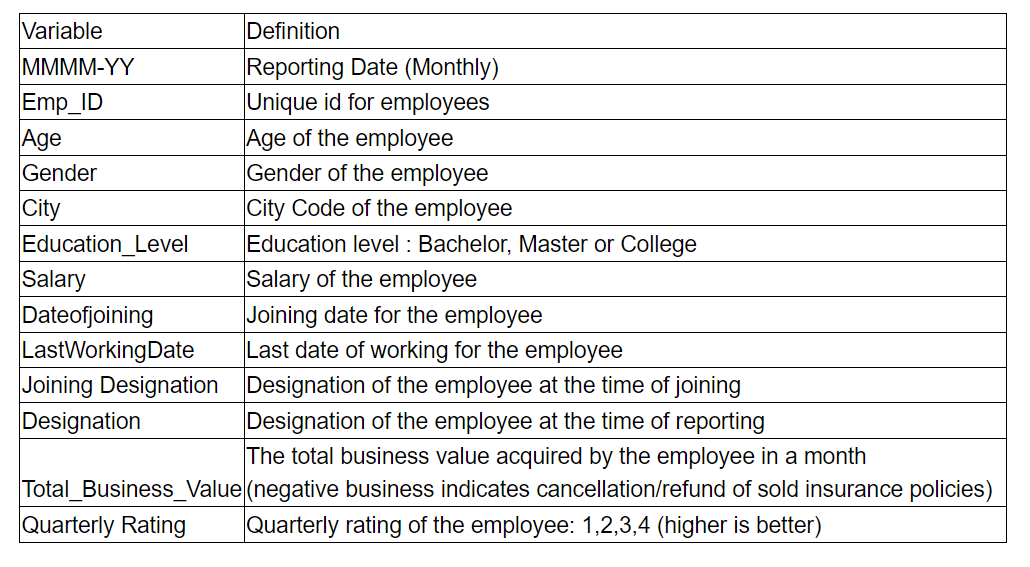

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler

## Reading Data

In [2]:
df_train = pd.read_csv("train_MpHjUjU.csv")
df_train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [3]:
df_test = pd.read_csv('test_hXY9mYw.csv')
df_test.head()

,Emp_ID
0,394
1,173
2,1090
3,840
4,308


## EDA on Data

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


Last working day is not present for a lot of employees as it is set only once an employee has decided to put down papers.

In [5]:
df_train.describe()

,Emp_ID,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.650283,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.264471,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [6]:
df_train.drop_duplicates(inplace=True)

In [7]:
# looking at data when an employee is leaving
df_train[~df_train['LastWorkingDate'].isna()].sample(5)

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
4588,2017-04-01,686,28,Female,C1,Master,62909,2016-11-02,2017-04-27,2,2,0,1
15951,2017-11-01,2369,31,Male,C14,College,14113,2017-03-06,2017-11-07,1,1,0,1
3929,2016-12-01,574,40,Male,C13,College,70144,2016-07-04,2016-11-29,2,2,255540,1
4600,2016-09-01,688,46,Female,C14,Bachelor,22931,2015-06-16,2016-09-22,1,2,194000,1
3194,2017-01-01,478,31,Female,C20,Bachelor,39164,2016-09-05,2017-01-04,2,2,0,1


In [8]:
df = df_train.copy()

#### Looking at features for people leaving

In [9]:
# Quarterly Rating
df[df['LastWorkingDate']>'2017-08-30']['Quarterly Rating'].unique()

array([1, 2, 3, 4], dtype=int64)

In [10]:
# Total Business Value
df[df['LastWorkingDate']>'2017-08-30']['Total Business Value'].unique()

array([      0, -300000,  500050,  149760,  155640,  196940,  271680,
        237500,  557750,  150000,  -14600,  360000,  184320,  299100,
        193600,  348630,  259680, -141140,  193430, -150800, 1519590,
       1023820,  150720,  300000,  104380, 1067760,  498020,  255480,
        224860, -305900,  102520,  993480,  245250,  350160,  241810,
       -200000, -154360, -191040,  200000, -478080,  162120], dtype=int64)

In [11]:
df[df['LastWorkingDate']>'2017-08-30']['Total Business Value'].value_counts()

 0          221
 149760       1
 1067760      1
-305900       1
 200000       1
 1023820      1
 104380       1
 193600       1
 993480       1
 150720       1
 557750       1
 241810       1
 102520       1
 259680       1
 299100       1
 360000       1
-191040       1
 245250       1
 184320       1
-154360       1
 155640       1
 150000       1
-150800       1
 1519590      1
 300000       1
-300000       1
 348630       1
 350160       1
 237500       1
 193430       1
 224860       1
-478080       1
 255480       1
 498020       1
-141140       1
 500050       1
 196940       1
 162120       1
 271680       1
-200000       1
-14600        1
Name: Total Business Value, dtype: int64

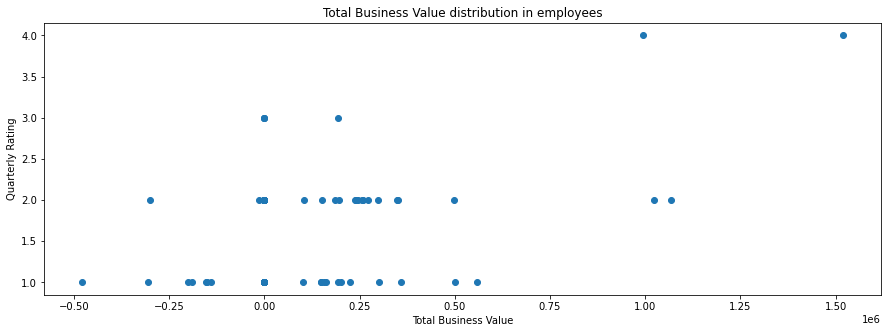

In [12]:
plt.figure(figsize=(15, 5))
width=0.1
plt.scatter(df[df['LastWorkingDate']>'2017-08-30']['Total Business Value'], df[df['LastWorkingDate']>'2017-08-30']['Quarterly Rating'])
plt.title('Total Business Value distribution in employees')

plt.xlabel('Total Business Value')
plt.ylabel('Quarterly Rating')
plt.show()


Most the employees are not adding any Business value and they are also given lower Quarterly Rating

In [13]:
df[df['LastWorkingDate']>'2017-08-30'].shape

(261, 13)

261 are leaving in the last quarter of 2017.

## Feature Engineering


    Adding new features-
    calculate change in designation from joining designation
    Calculate diff between joining and reposting date = reported_after_joining
    One hot encoding for categorical fields
    
    Updating existing features-
    consider lwd as person left.
    Education_Level to labels
    remove employee ID
    convert date from string to datetime format
    
    

In [14]:
datetime.datetime.strptime("2017-11-01", "%Y-%m-%d") - datetime.datetime.strptime("2017-11-30", "%Y-%m-%d")

datetime.timedelta(-29)

In [15]:
# Calculate diff between joining and reposting date = reported_after_joining
df['reported_after_joining'] = df['MMM-YY'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")) - df['Dateofjoining'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
df['reported_after_joining'] = df['reported_after_joining'].astype(str).apply(lambda x: x.split(' ')[0])

In [16]:
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,reported_after_joining
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2,8
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2,39
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,68
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1,-5
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1,25


### consider lwd as person left.

In [17]:
# df[~df['LastWorkingDate'].isna()]['Leaving'] = 1

In [18]:
df.loc[~df['LastWorkingDate'].isna(), 'Leaving']=1

In [19]:
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,reported_after_joining,Leaving
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2,8,NaN
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2,39,NaN
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,68,1.0
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1,-5,NaN
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1,25,NaN


In [20]:
df['Leaving'].fillna(0, inplace=True)

### Education_Level to labels

In [21]:
label = LabelEncoder()
label.fit(df['Education_Level'])
label.classes_

array(['Bachelor', 'College', 'Master'], dtype=object)

In [22]:
label.transform(['Bachelor', 'College', 'Master'])

array([0, 1, 2])

In [23]:
df['education_level_transformed'] = label.transform(df['Education_Level'])

### One hot encoding for categorical fields

In [24]:
df[['Female', 'Male']] = pd.get_dummies(df['Gender']).values

In [25]:
df['Change in Designation'] = df['Designation'] - df['Joining Designation']

In [26]:
dummy_df = pd.get_dummies(df['City'])
dummy_df.drop(columns=['C29'], axis=1, inplace=True)

In [27]:
new_df = pd.concat([df, dummy_df], join='outer', axis=1)

## creating test and training dataset

In [28]:
df_people_not_left = new_df.merge(df_test, on="Emp_ID")
print(df_people_not_left.shape, df_people_not_left['LastWorkingDate'].value_counts())

df_people_leaving = new_df[~new_df['Emp_ID'].isin(list(df_test.Emp_ID))]
print(df_people_leaving.Emp_ID.nunique())
df_people_leaving.head()

(8588, 47) Series([], Name: LastWorkingDate, dtype: int64)
1640


,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,...,C26,C27,C28,C3,C4,C5,C6,C7,C8,C9
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,...,0,0,0,0,0,0,0,0,0,0
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,...,0,0,0,0,0,0,0,0,0,0
5,2016-12-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,...,0,0,0,0,0,0,0,0,0,0
6,2017-01-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df_people_not_left.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,...,C26,C27,C28,C3,C4,C5,C6,C7,C8,C9
0,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,...,0,0,0,0,0,0,0,1,0,0
1,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,...,0,0,0,0,0,0,0,1,0,0
2,2017-08-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,...,0,0,0,0,0,0,0,0,0,0
3,2017-09-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,...,0,0,0,0,0,0,0,0,0,0
4,2017-10-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,...,0,0,0,0,0,0,0,0,0,0


#### Percentage of people leaving

In [30]:
(df_people_leaving['Leaving'].value_counts()[0]/df_people_leaving.shape[0])*100

84.63294028147584

In [31]:
(df_people_leaving['Leaving'].value_counts()[1]/df_people_leaving.shape[0])*100

15.367059718524153

In [32]:
df_people_leaving.shape

(10516, 47)

In [33]:
df = df_people_leaving.copy()

In [34]:
def plot_count_plot_leaving(df, column_name, width, figsize=(8, 5)):
    plt.figure(figsize=figsize)
    r=np.arange(2)
    for enm, col in enumerate(df[column_name].unique()):
        plt.bar(r+(enm*width), list(df[df[column_name]==col]['Leaving'].value_counts()), 
        width = width, label=col)
    plt.legend()
    plt.xticks([0+enm*(width/2),1+enm*(width/2)], ['Not Leaving', 'Leaving'])
    plt.title(f'Distribution of Employees leaving the organization wrt {column_name}')
    plt.show()

In [35]:
def plot_count_plot(df, column_name, figsize=(8, 5), direction='vertical'):
    plt.figure(figsize=figsize)
    if direction=='horizontal':
        df[column_name].value_counts().plot.barh()
    else:
        df[column_name].value_counts().plot.bar()
    plt.title(f'{column_name} distribution in employees')

    plt.show()

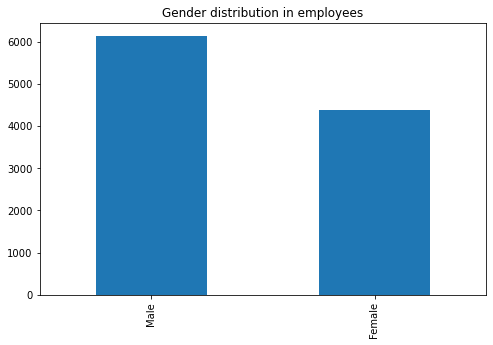

In [36]:
plot_count_plot(df, 'Gender', figsize=(8, 5))

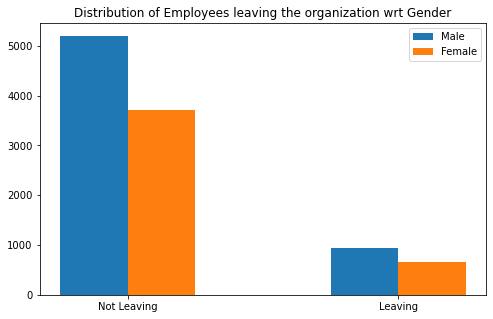

In [37]:
plot_count_plot_leaving(df, 'Gender', 0.25)

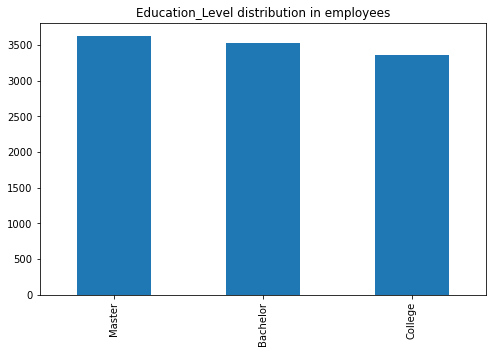

In [38]:
plot_count_plot(df, 'Education_Level', figsize=(8, 5))

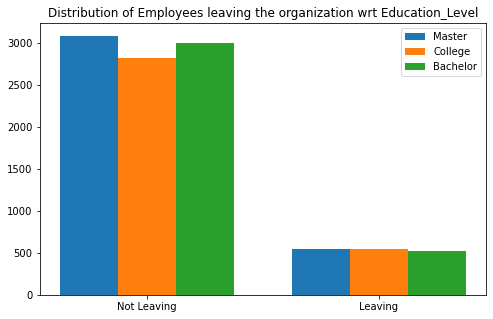

In [39]:
plot_count_plot_leaving(df, 'Education_Level', 0.25)

Employees with Bachelors degree are less likely to leave.

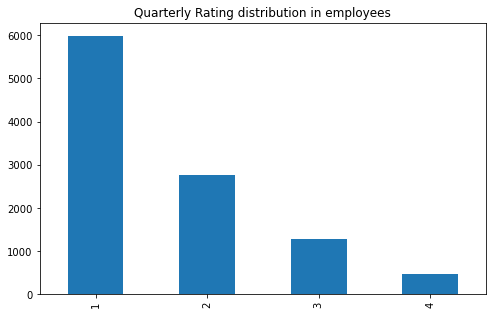

In [40]:
plot_count_plot(df, 'Quarterly Rating', figsize=(8, 5))

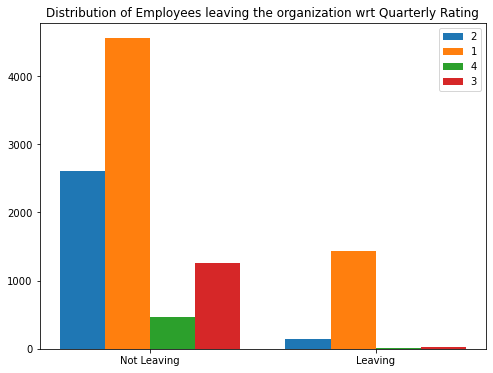

In [41]:
plot_count_plot_leaving(df, 'Quarterly Rating', 0.20, figsize=(8,6))

#### Probability of leaving the job increases for people with rating of 1

People who receive 1 Quarterly Rating are most likely to leave in comparison to other ratings. Most people are given 1 Quarterly Rating

In [42]:
# TO DO: checking for consequtive rating of 1


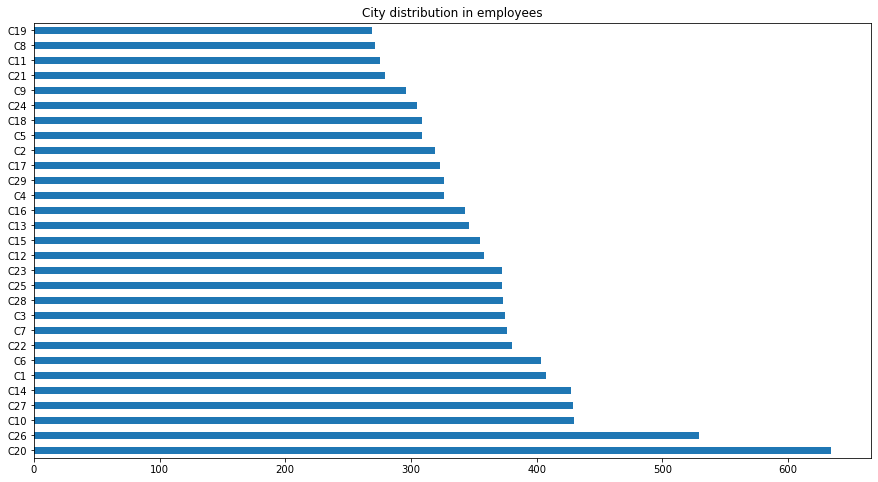

In [43]:
plot_count_plot(df, 'City', figsize=(15, 8), direction='horizontal')

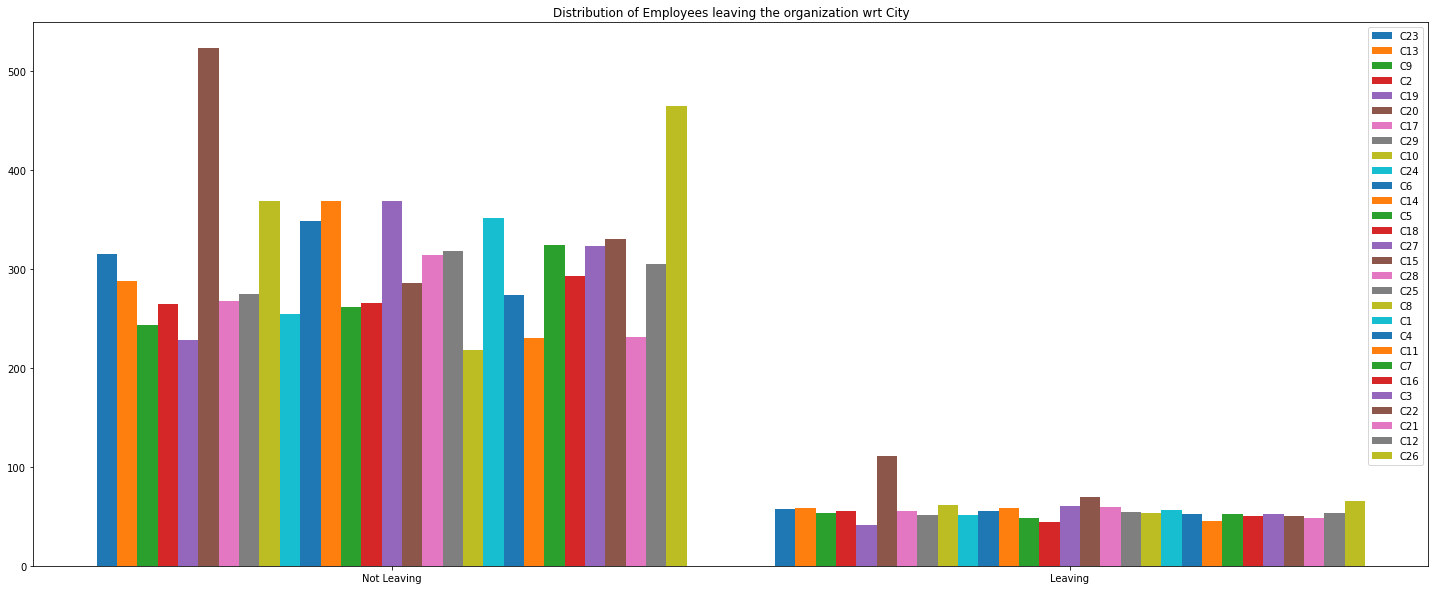

In [44]:
plot_count_plot_leaving(df, 'City', 0.03, (25, 10))

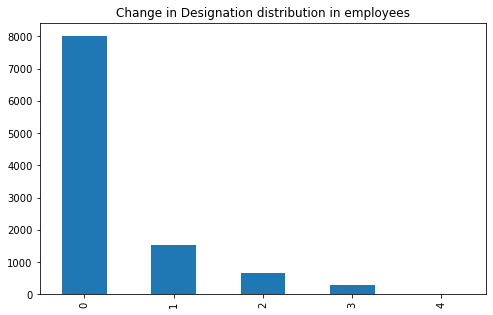

In [45]:
plot_count_plot(df, 'Change in Designation', figsize=(8, 5))

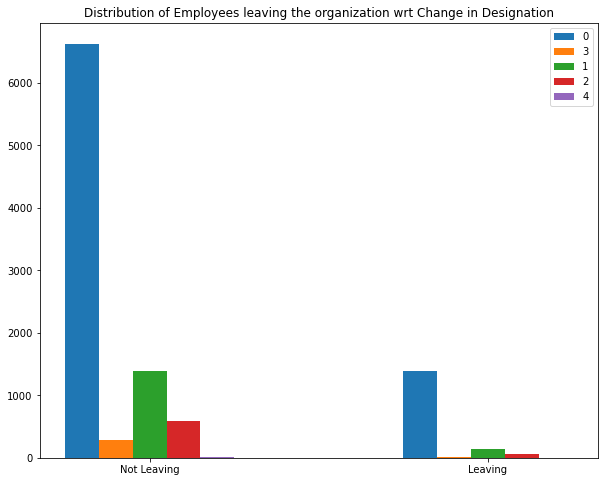

In [46]:
plot_count_plot_leaving(df, 'Change in Designation', 0.1, (10,8))

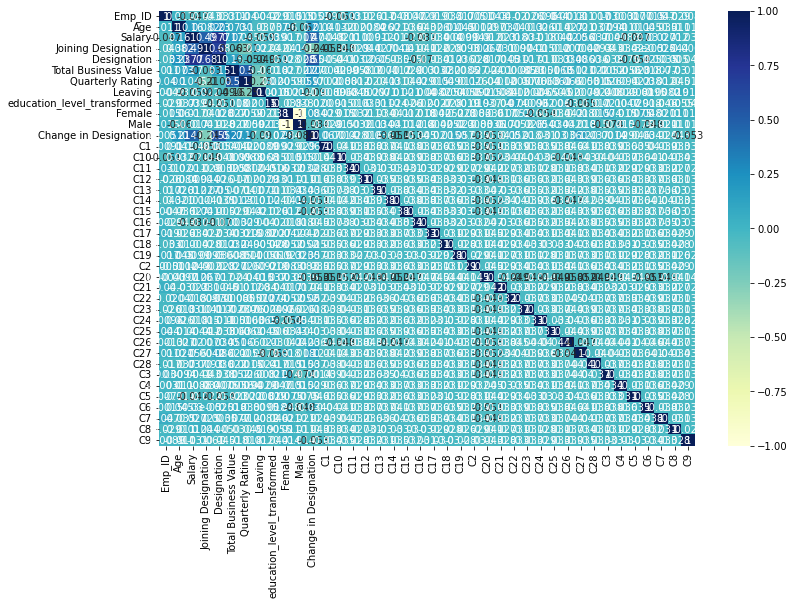

In [47]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

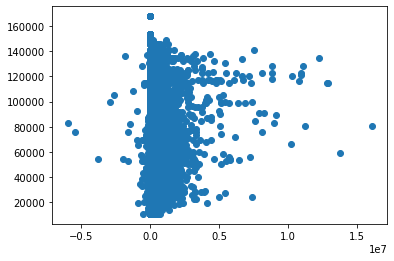

In [48]:
plt.scatter(df['Total Business Value'], df['Salary'], )

## Model Creation

In [49]:
df_people_not_left.shape # test set

(8588, 47)

In [50]:
df_people_leaving.shape # train_set

(10516, 47)

In [51]:
assert(df_people_leaving.shape[0]+df_people_not_left.shape[0]==new_df.shape[0])
assert(df_people_leaving.shape[1] == df_people_not_left.shape[1] == new_df.shape[1])
assert(df_people_leaving.columns.all() == df_people_not_left.columns.all() == new_df.columns.all())

In [52]:
# dataset dropping unneccesary features
X = df_people_leaving.drop(['Male', 'MMM-YY','Emp_ID', 'Age','Gender','City', 'Education_Level', 'Designation','Dateofjoining', 'LastWorkingDate', 'Leaving'], axis=1)
y = df_people_leaving['Leaving']

In [53]:
# City field after one hot encoding has resulted in lot of columns to training dataset. Using PCA to reduce the paramenters sent for training.
pca = PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
rclf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rclf_pca.fit(X_train, y_train)

print('accuracy',rclf_pca.score(X_test, y_test))
pred = rclf_pca.predict(X_test)
pred_train = rclf_pca.predict(X_train)

print('Train_score:')
print('f1_score',f1_score(y_train, pred_train))
print('recall_score',recall_score(y_train, pred_train))
print('precision_score',precision_score(y_train, pred_train))


print('\nTest_score:')
print('f1_score',f1_score(y_test, pred))
print('recall_score',recall_score(y_test, pred))
print('precision_score',precision_score(y_test, pred))

print('feature_importances_', rclf_pca.feature_importances_)

accuracy 0.8303082685105158
Train_score:
f1_score 0.999536822603057
recall_score 0.9990740740740741
precision_score 1.0

Test_score:
f1_score 0.31591173054587685
recall_score 0.2537313432835821
precision_score 0.41846153846153844
feature_importances_ [0.38219845 0.27566061 0.34214093]


In [54]:
X.shape, y.shape, X_train.shape, y_train.shape

((10516, 3), (10516,), (7045, 3), (7045,))

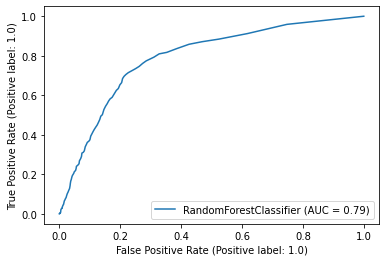

In [55]:
plot_roc_curve(rclf_pca, X_test, y_test)

In [56]:
# Using Random Forest on original dataset minus irrelevant fields
X = df_people_leaving.drop(['Male', 'MMM-YY','Emp_ID', 'Age','Gender','City', 'Education_Level', 'Designation','Dateofjoining', 'LastWorkingDate', 'Leaving'], axis=1)
y = df_people_leaving['Leaving']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
rclf = RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_split=2, n_jobs=-1)
rclf.fit(X_train, y_train)

print('accuracy',rclf.score(X_test, y_test))
pred = rclf.predict(X_test)
pred_train = rclf.predict(X_train)

print('Train_score:')
print('f1_score',f1_score(y_train, pred_train))
print('recall_score',recall_score(y_train, pred_train))
print('precision_score',precision_score(y_train, pred_train))


print('\nTest_score:')
print('f1_score',f1_score(y_test, pred))
print('recall_score',recall_score(y_test, pred))
print('precision_score',precision_score(y_test, pred))

print('feature_importances_', rclf.feature_importances_)

accuracy 0.8305963699222126
Train_score:
f1_score 1.0
recall_score 1.0
precision_score 1.0

Test_score:
f1_score 0.30660377358490565
recall_score 0.24253731343283583
precision_score 0.4166666666666667
feature_importances_ [0.15946993 0.03501453 0.15525919 0.05652412 0.35001159 0.03777908
 0.02286104 0.01548984 0.00573126 0.00670759 0.00514452 0.00682636
 0.00630222 0.00650241 0.00604772 0.00552923 0.00619083 0.00474394
 0.00438058 0.00674256 0.00837928 0.00549932 0.00502174 0.00596177
 0.00573422 0.00560524 0.00616202 0.00566731 0.00630693 0.00652056
 0.00605282 0.00552562 0.00587173 0.0061013  0.00598459 0.00634698]


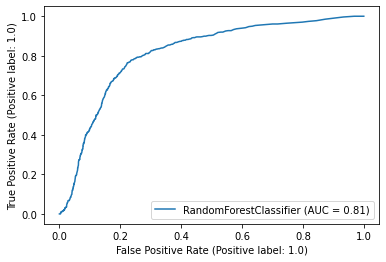

In [57]:
plot_roc_curve(rclf, X_test, y_test)

PCA did not help with precision and AUC scores. Will use SVM to see if it can improve on the results

In [58]:
X = df_people_leaving.drop(['Male', 'MMM-YY','Emp_ID', 'Age','Gender','City', 'Education_Level', 'Designation','Dateofjoining', 'LastWorkingDate', 'Leaving'], axis=1)
y = df_people_leaving['Leaving']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
sgdclf = SGDClassifier(random_state=42, max_iter=1000, early_stopping=True, class_weight='balanced')
sgdclf.fit(X_train, y_train)

print('accuracy',sgdclf.score(X_test, y_test))
pred = sgdclf.predict(X_test)
pred_train = sgdclf.predict(X_train)

print('Train_score:')
print('f1_score',f1_score(y_train, pred_train))
print('recall_score',recall_score(y_train, pred_train))
print('precision_score',precision_score(y_train, pred_train))


print('\nTest_score:')
print('f1_score',f1_score(y_test, pred))
print('recall_score',recall_score(y_test, pred))
print('precision_score',precision_score(y_test, pred))

accuracy 0.5937770095073466
Train_score:
f1_score 0.41383647798742135
recall_score 0.9138888888888889
precision_score 0.26747967479674795

Test_score:
f1_score 0.40152801358234297
recall_score 0.8824626865671642
precision_score 0.2598901098901099


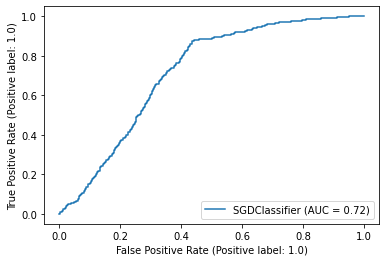

In [59]:
plot_roc_curve(sgdclf, X_test, y_test)

SVM turned out be worse than Random Forest with PCA

## Smote analysis

In [60]:
!pip install imblearn

In [61]:
print(f"original distribution: \n{y.value_counts()}" )

original distribution: 
0.0    8900
1.0    1616
Name: Leaving, dtype: int64


In [62]:
X = df_people_leaving.drop(['Male', 'MMM-YY','Emp_ID', 'Age','Gender','City', 'Education_Level', 'Designation','Dateofjoining', 'LastWorkingDate', 'Leaving'], axis=1)
y = df_people_leaving['Leaving']

oversample = RandomOverSampler(random_state=42)
X_over, y_over = oversample.fit_resample(X, y)

In [63]:
print(X_over.shape, y_over.shape)

(17800, 36) (17800,)


In [64]:
print(f"New distribution: \n{y_over.value_counts()}" )

New distribution: 
1.0    8900
0.0    8900
Name: Leaving, dtype: int64


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, random_state=42, test_size=0.33)
rclf_oversampling = RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_split=2, n_jobs=-1)
rclf_oversampling.fit(X_train, y_train)

print('accuracy',rclf_oversampling.score(X_test, y_test))
pred = rclf_oversampling.predict(X_test)
pred_train = rclf_oversampling.predict(X_train)

print('Train_score:')
print('f1_score',f1_score(y_train, pred_train))
print('recall_score',recall_score(y_train, pred_train))
print('precision_score',precision_score(y_train, pred_train))


print('\nTest_score:')
print('f1_score',f1_score(y_test, pred))
print('recall_score',recall_score(y_test, pred))
print('precision_score',precision_score(y_test, pred))

print('feature_importances_', rclf_oversampling.feature_importances_)


accuracy 0.9359891045284303
Train_score:
f1_score 1.0
recall_score 1.0
precision_score 1.0

Test_score:
f1_score 0.9392175881021662
recall_score 0.9837453437182526
precision_score 0.8985462418806063
feature_importances_ [0.11808398 0.02496969 0.24223173 0.09870778 0.32961117 0.02673477
 0.01640098 0.0158469  0.00482941 0.00500163 0.00480922 0.00489363
 0.00468912 0.00501103 0.00397183 0.00358308 0.0046878  0.00395418
 0.0039219  0.00591879 0.00559858 0.00381536 0.00449973 0.00536571
 0.00482741 0.00393357 0.00488431 0.00505485 0.00388666 0.00453125
 0.00394116 0.0037508  0.00440153 0.00522494 0.00418443 0.0042411 ]


In [66]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      2921
         1.0       0.90      0.98      0.94      2953

    accuracy                           0.94      5874
   macro avg       0.94      0.94      0.94      5874
weighted avg       0.94      0.94      0.94      5874



In [67]:
roc_auc_score(y_test, pred)

0.9357275160905538

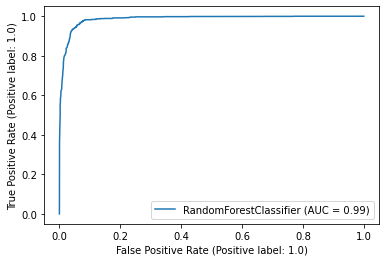

In [68]:
plot_roc_curve(rclf_oversampling, X_test, y_test)

## Testing on employees staying back

In [69]:
df_people_not_left.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8588 entries, 0 to 8587
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   MMM-YY                       8588 non-null   object 
 1   Emp_ID                       8588 non-null   int64  
 2   Age                          8588 non-null   int64  
 3   Gender                       8588 non-null   object 
 4   City                         8588 non-null   object 
 5   Education_Level              8588 non-null   object 
 6   Salary                       8588 non-null   int64  
 7   Dateofjoining                8588 non-null   object 
 8   LastWorkingDate              0 non-null      object 
 9   Joining Designation          8588 non-null   int64  
 10  Designation                  8588 non-null   int64  
 11  Total Business Value         8588 non-null   int64  
 12  Quarterly Rating             8588 non-null   int64  
 13  reported_after_joi

In [70]:
df_people_not_left.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,...,C26,C27,C28,C3,C4,C5,C6,C7,C8,C9
0,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,...,0,0,0,0,0,0,0,1,0,0
1,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,...,0,0,0,0,0,0,0,1,0,0
2,2017-08-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,...,0,0,0,0,0,0,0,0,0,0
3,2017-09-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,...,0,0,0,0,0,0,0,0,0,0
4,2017-10-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,...,0,0,0,0,0,0,0,0,0,0


In [71]:
test_set = df_people_not_left.drop(['Male', 'MMM-YY','Emp_ID', 'Age','Gender','City', 'Education_Level', 'Designation','Dateofjoining', 'LastWorkingDate', 'Leaving'], axis=1)
test_predicted = rclf_oversampling.predict(test_set)

In [72]:
dummy_test = pd.DataFrame(df_people_not_left['Emp_ID'])
dummy_test['Target'] = test_predicted

In [73]:
dummy_test['Target'].value_counts()

0.0    8159
1.0     429
Name: Target, dtype: int64

In [74]:
dummy_test.Emp_ID.value_counts()

893     24
2228    24
213     24
1841    24
2308    24
        ..
715      1
2770     1
2778     1
1195     1
1955     1
Name: Emp_ID, Length: 741, dtype: int64

In [75]:
df_test.merge(dummy_test, how='inner').drop_duplicates()

,Emp_ID,Target
0,394,0.0
24,173,0.0
48,1090,0.0
72,840,0.0
96,308,0.0
...,...,...
8536,448,1.0
8540,1644,0.0
8562,1644,1.0
8564,624,0.0


In [76]:
dummy_2 = df_test.merge(dummy_test, how='inner').drop_duplicates()
dummy_1 = dummy_2[dummy_2['Target'] == 1]

In [77]:
dummy_0 = dummy_2[(dummy_2['Target'] == 0) & (~dummy_2['Emp_ID'].isin(dummy_1['Emp_ID']))]

In [78]:
df_test.shape

(741, 1)

In [79]:
submission_df = pd.concat([dummy_0, dummy_1])

In [80]:
submission_df['Target'].value_counts()

0.0    511
1.0    230
Name: Target, dtype: int64

In [81]:
submission_df.to_csv('submission.csv', index=False)